<a href="https://colab.research.google.com/github/faizankshaikh/HomMul/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with Self-Playing Deep Reinforcement Learning


## Initializing the game

In [1]:
#@title Required installation
# !pip install -q black gymnasium pettingzoo==1.22.3 tianshou
# !git clone https://github.com/faizankshaikh/HomMul.git

In [2]:
#@title Change working path
%cd HomMul/

/content/HomMul


In [3]:
#@title Import libraries and modules
%load_ext tensorboard

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler

from hommul.envs.hommul_v0 import HomMul

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

from torch.utils.tensorboard import SummaryWriter

In [4]:
#@title Setup Gymnasium environment
env = HomMul()
original_env = HomMul(render_mode="human")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#@title Example of gameplay
episodes = 2

for episode in range(episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)
    obs = original_env.reset()
    print()

    while original_env.agents:
        acts = {
            "player1": np.random.choice([0, 1]),
            "player2": np.random.choice([0, 1])
        }
        print(f"--Action taken by player 1: {original_env.action_dict[acts['player1']]}")
        print(f"--Action taken by player 2: {original_env.action_dict[acts['player2']]}")
        print()

        obs, rews, terms, truncs, infos = original_env.step(acts)
        print()

Episode #1
--Days left: 2
--Current life of agent 1: 3
--Current life of agent 2: 3
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2

--Action taken by player 1: play
--Action taken by player 2: play

--Days left: 1
--Current life of agent 1: 3
--Current life of agent 2: 3
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4
--Previous action of agent 1: play
--Previous action of agent 2: play

--Action taken by player 1: wait
--Action taken by player 2: wait

--Days left: 0
--Current life of agent 1: 2
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4
--Previous action of agent 1: wait
--Previous action of agent 2: wait

Episode #2
--Days left: 2
--Current life of agent 1: 3
--Current life of agent 2: 3
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2

--Action taken by player 1: wait
--Action taken by player 2: play

--Days left: 

## Heuristics Benchmarking


death rate (in %) of player1: 37.4 +- 8.812
death rate (in %) of player2: 33.8 +- 6.425


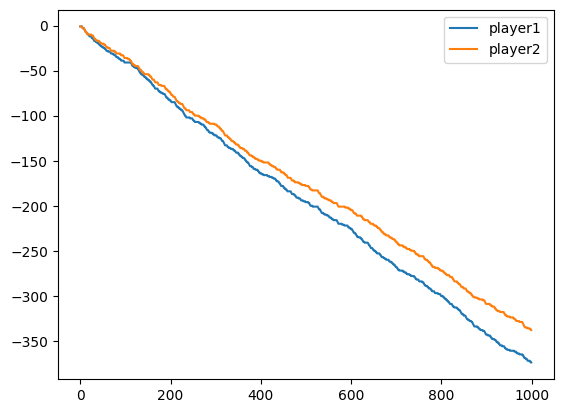

In [6]:
#@title Case - both always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)

interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")

plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 61.2 +- 6.828
death rate (in %) of player2: 44.7 +- 6.202


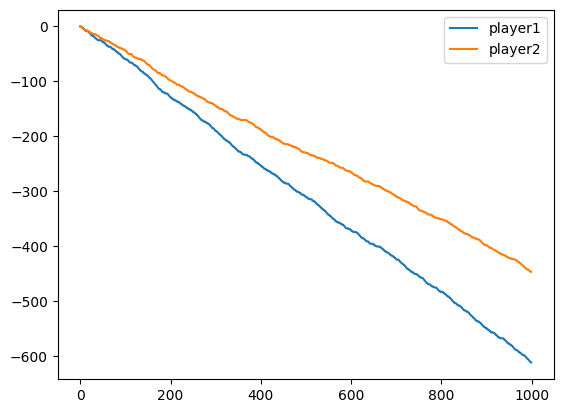

In [7]:
#@title Case - both always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 63.4 +- 7.767
death rate (in %) of player2: 55.3 +- 8.239


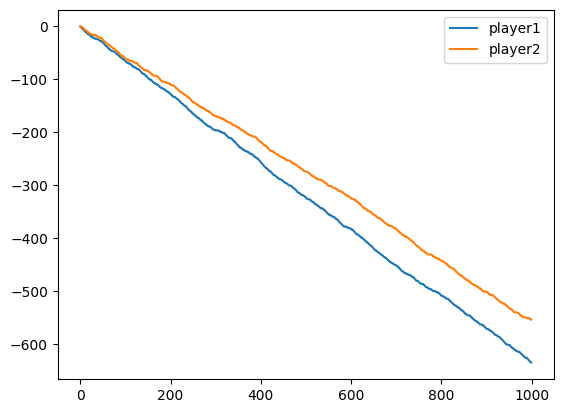

In [8]:
#@title Case - player1 waits, player2 plays
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 60.6 +- 6.250
death rate (in %) of player2: 44.8 +- 8.000


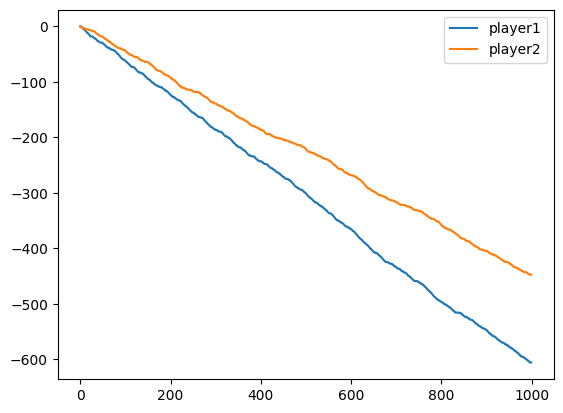

In [9]:
#@title Case - player1 plays, player2 waits
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 49.0 +- 10.685
death rate (in %) of player2: 37.3 +- 4.422


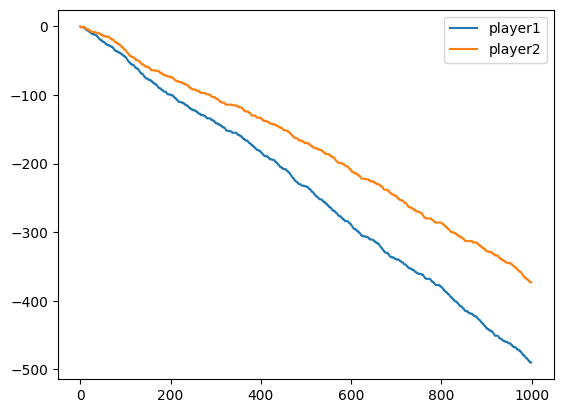

In [10]:
#@title Case - Always play vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 65.8 +- 6.880
death rate (in %) of player2: 51.8 +- 6.898


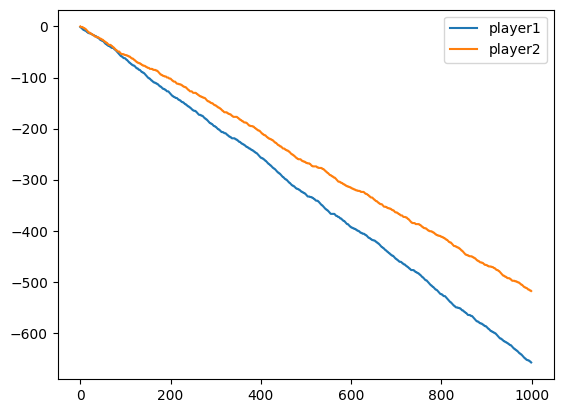

In [11]:
#@title Case - Always wait vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 55.7 +- 4.740
death rate (in %) of player2: 20.5 +- 5.946


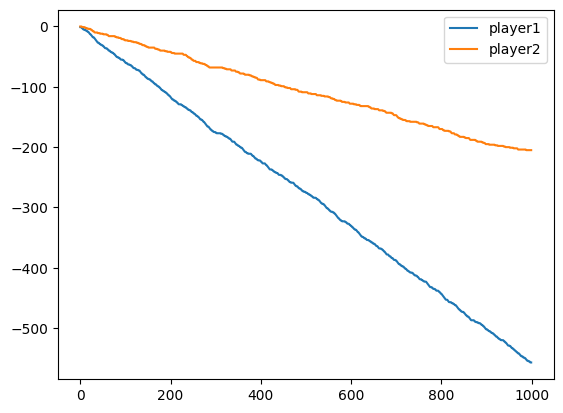

In [12]:
#@title Case - Always play vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 66.7 +- 9.480
death rate (in %) of player2: 31.3 +- 4.320


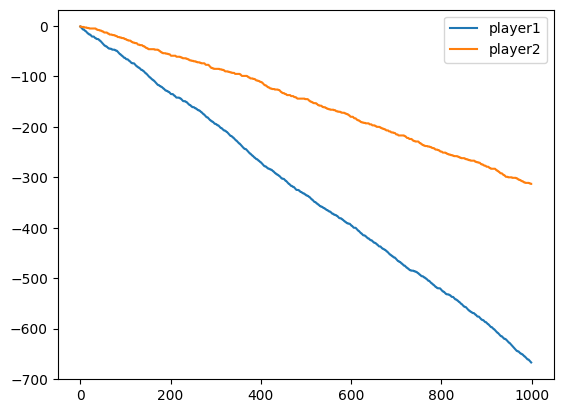

In [16]:
#@title Case - Always wait vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [17]:
#@title Load optimal policy

def optimal(obs):
    df = pd.read_csv("models/optimal_policy.csv")
    return df.loc[
        (df["days_left"] == obs["player1"]["observation"][0][0]) &
        (df["player1_life_points"] == obs["player1"]["observation"][0][1]) &
        (df["player2_life_points"] == obs["player1"]["observation"][0][2]) &
        (df["player1_prob_payoff"] == obs["player1"]["observation"][0][3])
    ]["action"].values[0] - 1

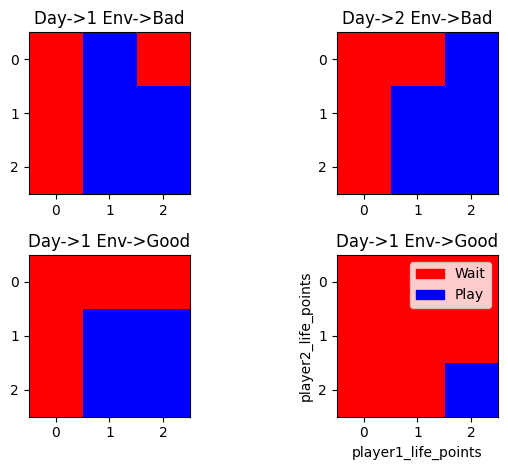

In [18]:
#@title Visualize optimal policy

df = pd.read_csv("models/optimal_policy.csv")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

arr = df.loc[(df["days_left"] == 1) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] < 0.3), "action"].values

ax1.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax1.set_title("Day->1 Env->Bad")

arr = df.loc[(df["days_left"] == 2) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] < 0.3), "action"].values

ax2.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax2.set_title("Day->2 Env->Bad")

arr = df.loc[(df["days_left"] == 1) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] > 0.3), "action"].values

ax3.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax3.set_title("Day->1 Env->Good")

arr = df.loc[(df["days_left"] == 2) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] > 0.3), "action"].values

ax = ax4.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax4.set_title("Day->1 Env->Good")
ax4.set_xlabel("player1_life_points")
ax4.set_ylabel("player2_life_points")

red_patch = mpatches.Patch(color='red', label='Wait')
blue_patch = mpatches.Patch(color='blue', label='Play')

plt.legend(handles=[red_patch, blue_patch])

fig.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate (in %) of player1: 55.2 +- 6.646
death rate (in %) of player2: 44.7 +- 6.214


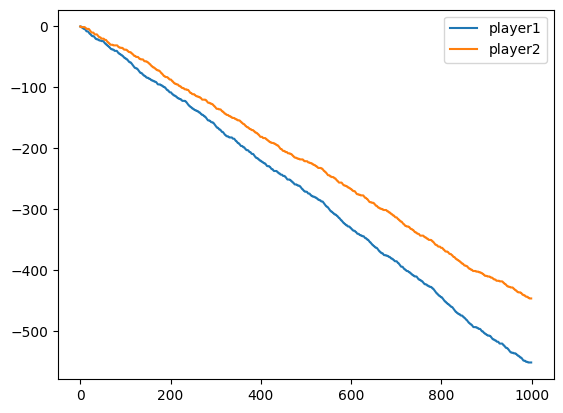

In [19]:
#@title Case - optimal vs Always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": optimal(obs),
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate (in %) of player1: 52.3 +- 7.613
death rate (in %) of player2: 45.7 +- 5.944


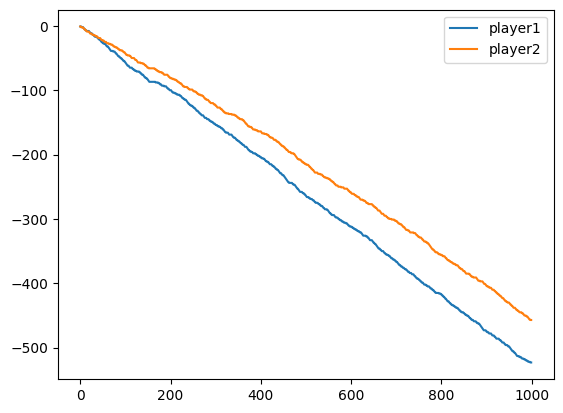

In [20]:
#@title Case - optimal vs Always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": optimal(obs), 
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate (in %) of player1: 44.6 +- 5.520
death rate (in %) of player2: 18.4 +- 6.762


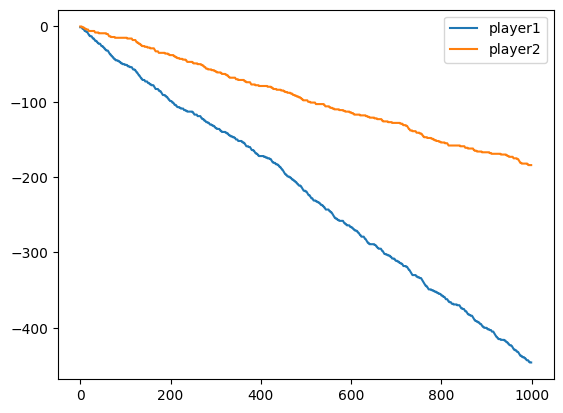

In [21]:
#@title Case - optimal vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": optimal(obs),
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate (in %) of player1: 33.3 +- 4.629
death rate (in %) of player2: 20.8 +- 6.500


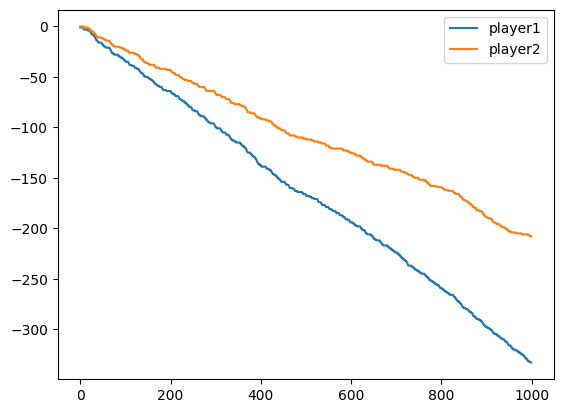

In [22]:
#@title Case - optimal vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": optimal(obs),
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

## Deep RL training


In [23]:
#@title Define heuristic algos in Tianshou
## agent that always plays
class AlwaysPlay(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)
    
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always waits
class AlwaysWait(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to play
class HailMary(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 2] <= 1:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## optimal agent 
class OptimalPolicy(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        df = pd.read_csv("models/optimal_policy.csv")

        for i in range(mask.shape[0]):
            action = df.loc[
                (df["days_left"] == obs[i, :, 0][0]) &
                (df["player1_life_points"] == obs[i, :, 1][0]) &
                (df["player2_life_points"] == obs[i, :, 2][0]) &
                (df["player1_prob_payoff"] == obs[i, :, 3][0])
            ]["action"].values[0] - 1
            if action:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
#@title Prerequisites for training
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env():
    env = HomMul()
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

# seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = HomMul()
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent(pretrained=False):
    vec_env = _get_env()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        device="cuda",
    ).to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    model = DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=50,
    )

    if pretrained:
        model_save_path = os.path.join("models", "vs_hail_mary.pth")
        model.load_state_dict(torch.load(model_save_path))
    return model

agent_learn1 = _get_agent(pretrained=True)
agent_learn2 = _get_agent(pretrained=True)

train_policies = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env())

train_envs = DummyVectorEnv([_get_env for _ in range(5)])
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
train_envs.seed(seed)
test_envs.seed(seed)

# Step 4: Collector setup
train_collector = Collector(
    train_policies,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)

test_policies = MultiAgentPolicyManager([OptimalPolicy(), agent_learn2],  _get_env())
test_collector = Collector(test_policies, test_envs, exploration_noise=True)

train_collector.collect(n_step=50)

def save_best_fn(policy):
    model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    os.makedirs(os.path.join("log", "hommul", "dqn"), exist_ok=True)
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        torch.save(train_policies.policies[agents[0]].state_dict(), model_save_path1)
    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        torch.save(train_policies.policies[agents[1]].state_dict(), model_save_path2)

def stop_fn(mean_rewards):
    return mean_rewards >= -0.1

def train_fn(epoch, env_step):
    # freeze training for player1
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].set_eps(0.05)

    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        train_policies.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].set_eps(0.05)

    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        train_policies.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

In [25]:
#@title Clear logs and setup TensorBoard
!rm -rf /content/HomMul/log

log_path = os.path.join("log", "hommul", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Evolution 1


Epoch #1: 1001it [00:03, 308.85it/s, env_step=1000, len=2, n/ep=18, n/st=50, player1/loss=0.395, player2/loss=0.449, rew=-0.39]                          


Epoch #1: test_reward: -0.240000 ± 0.427083, best_reward: -0.190000 ± 0.392301 in #0


Epoch #2: 1001it [00:01, 663.37it/s, env_step=2000, len=3, n/ep=16, n/st=50, player1/loss=0.309, player2/loss=0.453, rew=-0.38]                          


Epoch #2: test_reward: -0.290000 ± 0.453762, best_reward: -0.190000 ± 0.392301 in #0


Epoch #3: 1001it [00:01, 700.86it/s, env_step=3000, len=3, n/ep=18, n/st=50, player1/loss=0.327, player2/loss=0.479, rew=-0.17]                          


Epoch #3: test_reward: -0.320000 ± 0.466476, best_reward: -0.190000 ± 0.392301 in #0


Epoch #4: 1001it [00:01, 686.06it/s, env_step=4000, len=3, n/ep=15, n/st=50, player1/loss=0.359, player2/loss=0.525, rew=-0.07]                          


Epoch #4: test_reward: -0.240000 ± 0.427083, best_reward: -0.190000 ± 0.392301 in #0


Epoch #5: 1001it [00:01, 709.62it/s, env_step=5000, len=3, n/ep=16, n/st=50, player1/loss=0.336, player2/loss=0.540, rew=-0.12]                          


Epoch #5: test_reward: -0.300000 ± 0.458258, best_reward: -0.190000 ± 0.392301 in #0


Epoch #6: 1001it [00:01, 630.89it/s, env_step=6000, len=2, n/ep=19, n/st=50, player1/loss=0.351, player2/loss=0.542, rew=-0.26]                          


Epoch #6: test_reward: -0.350000 ± 0.476970, best_reward: -0.190000 ± 0.392301 in #0


Epoch #7: 1001it [00:01, 516.21it/s, env_step=7000, len=3, n/ep=17, n/st=50, player1/loss=0.318, player2/loss=0.582, rew=-0.35]                          


Epoch #7: test_reward: -0.320000 ± 0.466476, best_reward: -0.190000 ± 0.392301 in #0


Epoch #8: 1001it [00:01, 695.06it/s, env_step=8000, len=2, n/ep=19, n/st=50, player1/loss=0.339, player2/loss=0.602, rew=-0.47]                          


Epoch #8: test_reward: -0.260000 ± 0.438634, best_reward: -0.190000 ± 0.392301 in #0


Epoch #9: 1001it [00:01, 707.50it/s, env_step=9000, len=2, n/ep=19, n/st=50, player1/loss=0.379, player2/loss=0.649, rew=-0.26]                          


Epoch #9: test_reward: -0.270000 ± 0.443959, best_reward: -0.190000 ± 0.392301 in #0


Epoch #10: 1001it [00:01, 691.58it/s, env_step=10000, len=3, n/ep=15, n/st=50, player1/loss=0.359, player2/loss=0.638, rew=-0.20]                          


Epoch #10: test_reward: -0.300000 ± 0.458258, best_reward: -0.190000 ± 0.392301 in #0


Epoch #11: 1001it [00:01, 719.24it/s, env_step=11000, len=2, n/ep=16, n/st=50, player1/loss=0.351, player2/loss=0.672, rew=-0.12]                          


Epoch #11: test_reward: -0.240000 ± 0.427083, best_reward: -0.190000 ± 0.392301 in #0


Epoch #12: 1001it [00:01, 698.19it/s, env_step=12000, len=3, n/ep=16, n/st=50, player1/loss=0.348, player2/loss=0.693, rew=-0.25]                          


Epoch #12: test_reward: -0.250000 ± 0.433013, best_reward: -0.190000 ± 0.392301 in #0


Epoch #13: 1001it [00:01, 533.73it/s, env_step=13000, len=2, n/ep=18, n/st=50, player1/loss=0.388, player2/loss=0.713, rew=-0.22]                          


Epoch #13: test_reward: -0.260000 ± 0.438634, best_reward: -0.190000 ± 0.392301 in #0


Epoch #14: 1001it [00:01, 658.75it/s, env_step=14000, len=2, n/ep=20, n/st=50, player1/loss=0.358, player2/loss=0.752, rew=-0.30]                          


Epoch #14: test_reward: -0.310000 ± 0.462493, best_reward: -0.190000 ± 0.392301 in #0


Epoch #15: 1001it [00:01, 689.96it/s, env_step=15000, len=3, n/ep=16, n/st=50, player1/loss=0.342, player2/loss=0.738, rew=-0.44]                          


Epoch #15: test_reward: -0.300000 ± 0.458258, best_reward: -0.190000 ± 0.392301 in #0


Epoch #16: 1001it [00:01, 692.96it/s, env_step=16000, len=2, n/ep=19, n/st=50, player1/loss=0.359, player2/loss=0.759, rew=-0.16]                          


Epoch #16: test_reward: -0.280000 ± 0.448999, best_reward: -0.190000 ± 0.392301 in #0


Epoch #17: 1001it [00:01, 695.22it/s, env_step=17000, len=2, n/ep=22, n/st=50, player1/loss=0.372, player2/loss=0.811, rew=-0.05]                          


Epoch #17: test_reward: -0.200000 ± 0.400000, best_reward: -0.190000 ± 0.392301 in #0


Epoch #18: 1001it [00:01, 684.49it/s, env_step=18000, len=2, n/ep=16, n/st=50, player1/loss=0.386, player2/loss=0.780, rew=-0.19]                          


Epoch #18: test_reward: -0.290000 ± 0.453762, best_reward: -0.190000 ± 0.392301 in #0


Epoch #19: 1001it [00:01, 592.71it/s, env_step=19000, len=3, n/ep=17, n/st=50, player1/loss=0.382, player2/loss=0.766, rew=-0.12]                          


Epoch #19: test_reward: -0.290000 ± 0.453762, best_reward: -0.190000 ± 0.392301 in #0


Epoch #20: 1001it [00:01, 542.65it/s, env_step=20000, len=2, n/ep=18, n/st=50, player1/loss=0.368, player2/loss=0.777, rew=-0.28]                          


Epoch #20: test_reward: -0.310000 ± 0.462493, best_reward: -0.190000 ± 0.392301 in #0
##########

death rate (in %) of player1: 39.8 +- 7.529
death rate (in %) of player2: 19.2 +- 7.024


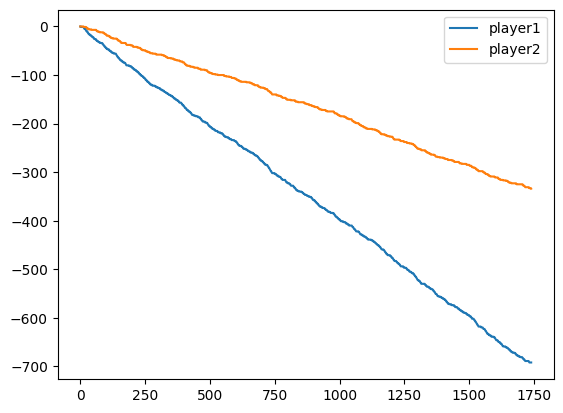


#### Evolution 2


Epoch #1: 1001it [00:01, 552.08it/s, env_step=1000, len=3, n/ep=14, n/st=50, player1/loss=0.390, player2/loss=0.507, rew=-0.29]                          


Epoch #1: test_reward: -0.310000 ± 0.462493, best_reward: -0.190000 ± 0.392301 in #0


Epoch #2: 1001it [00:01, 579.88it/s, env_step=2000, len=3, n/ep=15, n/st=50, player1/loss=0.354, player2/loss=0.487, rew=-0.33]                          


Epoch #2: test_reward: -0.310000 ± 0.462493, best_reward: -0.190000 ± 0.392301 in #0


Epoch #3: 1001it [00:01, 540.87it/s, env_step=3000, len=3, n/ep=15, n/st=50, player1/loss=0.346, player2/loss=0.456, rew=-0.27]                          


Epoch #3: test_reward: -0.430000 ± 0.495076, best_reward: -0.190000 ± 0.392301 in #0


Epoch #4: 1001it [00:02, 470.86it/s, env_step=4000, len=3, n/ep=16, n/st=50, player1/loss=0.331, player2/loss=0.499, rew=0.00]                          


Epoch #4: test_reward: -0.290000 ± 0.453762, best_reward: -0.190000 ± 0.392301 in #0


Epoch #5: 1001it [00:01, 696.17it/s, env_step=5000, len=3, n/ep=17, n/st=50, player1/loss=0.339, player2/loss=0.498, rew=-0.24]                          


Epoch #5: test_reward: -0.380000 ± 0.485386, best_reward: -0.190000 ± 0.392301 in #0


Epoch #6: 1001it [00:01, 719.59it/s, env_step=6000, len=3, n/ep=18, n/st=50, player1/loss=0.351, player2/loss=0.474, rew=-0.11]                          


Epoch #6: test_reward: -0.290000 ± 0.453762, best_reward: -0.190000 ± 0.392301 in #0


Epoch #7: 1001it [00:01, 545.64it/s, env_step=7000, len=3, n/ep=17, n/st=50, player1/loss=0.355, player2/loss=0.478, rew=-0.12]                          


Epoch #7: test_reward: -0.250000 ± 0.433013, best_reward: -0.190000 ± 0.392301 in #0


Epoch #8: 1001it [00:01, 605.77it/s, env_step=8000, len=2, n/ep=20, n/st=50, player1/loss=0.324, player2/loss=0.490, rew=-0.35]                          


Epoch #8: test_reward: -0.330000 ± 0.470213, best_reward: -0.190000 ± 0.392301 in #0


Epoch #9: 1001it [00:01, 732.77it/s, env_step=9000, len=3, n/ep=14, n/st=50, player1/loss=0.319, player2/loss=0.499, rew=-0.36]                          


Epoch #9: test_reward: -0.330000 ± 0.470213, best_reward: -0.190000 ± 0.392301 in #0


Epoch #10: 1001it [00:01, 725.34it/s, env_step=10000, len=2, n/ep=18, n/st=50, player1/loss=0.327, player2/loss=0.510, rew=-0.39]                          


Epoch #10: test_reward: -0.290000 ± 0.453762, best_reward: -0.190000 ± 0.392301 in #0


Epoch #11: 1001it [00:01, 718.77it/s, env_step=11000, len=2, n/ep=18, n/st=50, player1/loss=0.325, player2/loss=0.524, rew=-0.28]                          


Epoch #11: test_reward: -0.210000 ± 0.407308, best_reward: -0.190000 ± 0.392301 in #0


Epoch #12: 1001it [00:01, 725.40it/s, env_step=12000, len=2, n/ep=17, n/st=50, player1/loss=0.317, player2/loss=0.566, rew=-0.29]                          


Epoch #12: test_reward: -0.300000 ± 0.458258, best_reward: -0.190000 ± 0.392301 in #0


Epoch #13: 1001it [00:01, 708.11it/s, env_step=13000, len=2, n/ep=18, n/st=50, player1/loss=0.305, player2/loss=0.566, rew=-0.50]                          


Epoch #13: test_reward: -0.250000 ± 0.433013, best_reward: -0.190000 ± 0.392301 in #0


Epoch #14: 1001it [00:01, 516.63it/s, env_step=14000, len=3, n/ep=17, n/st=50, player1/loss=0.299, player2/loss=0.580, rew=-0.29]                          


Epoch #14: test_reward: -0.280000 ± 0.448999, best_reward: -0.190000 ± 0.392301 in #0


Epoch #15: 1001it [00:01, 687.40it/s, env_step=15000, len=2, n/ep=17, n/st=50, player1/loss=0.306, player2/loss=0.566, rew=-0.41]                          


Epoch #15: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #15


Epoch #16: 1001it [00:01, 707.03it/s, env_step=16000, len=3, n/ep=15, n/st=50, player1/loss=0.298, player2/loss=0.598, rew=-0.13]                          


Epoch #16: test_reward: -0.190000 ± 0.392301, best_reward: -0.170000 ± 0.375633 in #15


Epoch #17: 1001it [00:01, 707.13it/s, env_step=17000, len=3, n/ep=18, n/st=50, player1/loss=0.306, player2/loss=0.620, rew=-0.11]                          


Epoch #17: test_reward: -0.200000 ± 0.400000, best_reward: -0.170000 ± 0.375633 in #15


Epoch #18: 1001it [00:01, 701.94it/s, env_step=18000, len=2, n/ep=17, n/st=50, player1/loss=0.303, player2/loss=0.677, rew=-0.29]                          


Epoch #18: test_reward: -0.210000 ± 0.407308, best_reward: -0.170000 ± 0.375633 in #15


Epoch #19: 1001it [00:01, 683.52it/s, env_step=19000, len=2, n/ep=20, n/st=50, player1/loss=0.328, player2/loss=0.682, rew=-0.25]                          


Epoch #19: test_reward: -0.220000 ± 0.414246, best_reward: -0.170000 ± 0.375633 in #15


Epoch #20: 1001it [00:01, 536.37it/s, env_step=20000, len=2, n/ep=18, n/st=50, player1/loss=0.340, player2/loss=0.671, rew=-0.28]                          


Epoch #20: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #15
##########

death rate (in %) of player1: 36.9 +- 5.375
death rate (in %) of player2: 27.7 +- 6.226


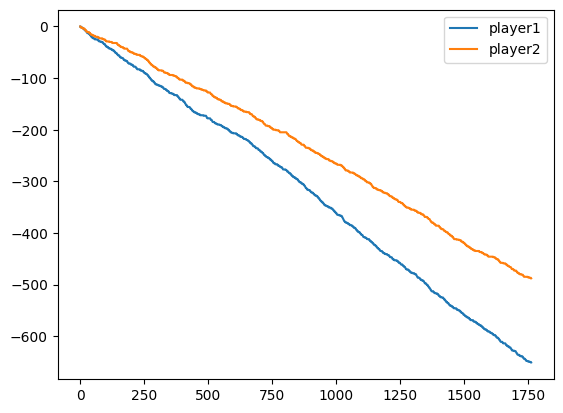


#### Evolution 3


Epoch #1: 1001it [00:01, 716.86it/s, env_step=1000, len=2, n/ep=18, n/st=50, player1/loss=0.482, player2/loss=0.640, rew=-0.39]                          


Epoch #1: test_reward: -0.290000 ± 0.453762, best_reward: -0.250000 ± 0.433013 in #0


Epoch #2: 1001it [00:01, 536.79it/s, env_step=2000, len=2, n/ep=17, n/st=50, player1/loss=0.420, player2/loss=0.628, rew=-0.24]                          


Epoch #2: test_reward: -0.280000 ± 0.448999, best_reward: -0.250000 ± 0.433013 in #0


Epoch #3: 1001it [00:01, 595.23it/s, env_step=3000, len=3, n/ep=16, n/st=50, player1/loss=0.416, player2/loss=0.609, rew=-0.12]                          


Epoch #3: test_reward: -0.220000 ± 0.414246, best_reward: -0.220000 ± 0.414246 in #3


Epoch #4: 1001it [00:01, 702.80it/s, env_step=4000, len=2, n/ep=18, n/st=50, player1/loss=0.421, player2/loss=0.608, rew=-0.22]                          


Epoch #4: test_reward: -0.240000 ± 0.427083, best_reward: -0.220000 ± 0.414246 in #3


Epoch #5: 1001it [00:01, 696.26it/s, env_step=5000, len=2, n/ep=17, n/st=50, player1/loss=0.372, player2/loss=0.654, rew=-0.29]                          


Epoch #5: test_reward: -0.210000 ± 0.407308, best_reward: -0.210000 ± 0.407308 in #5


Epoch #6: 1001it [00:01, 718.49it/s, env_step=6000, len=2, n/ep=19, n/st=50, player1/loss=0.369, player2/loss=0.640, rew=-0.37]                          


Epoch #6: test_reward: -0.180000 ± 0.384187, best_reward: -0.180000 ± 0.384187 in #6


Epoch #7: 1001it [00:01, 658.62it/s, env_step=7000, len=2, n/ep=18, n/st=50, player1/loss=0.371, player2/loss=0.636, rew=-0.11]                          


Epoch #7: test_reward: -0.220000 ± 0.414246, best_reward: -0.180000 ± 0.384187 in #6


Epoch #8: 1001it [00:01, 629.09it/s, env_step=8000, len=3, n/ep=18, n/st=50, player1/loss=0.374, player2/loss=0.623, rew=-0.56]                          


Epoch #8: test_reward: -0.140000 ± 0.346987, best_reward: -0.140000 ± 0.346987 in #8


Epoch #9: 1001it [00:01, 518.60it/s, env_step=9000, len=2, n/ep=16, n/st=50, player1/loss=0.352, player2/loss=0.573, rew=-0.31]                          


Epoch #9: test_reward: -0.200000 ± 0.400000, best_reward: -0.140000 ± 0.346987 in #8


Epoch #10: 1001it [00:01, 689.47it/s, env_step=10000, len=2, n/ep=17, n/st=50, player1/loss=0.352, player2/loss=0.578, rew=-0.47]                          


Epoch #10: test_reward: -0.190000 ± 0.392301, best_reward: -0.140000 ± 0.346987 in #8


Epoch #11: 1001it [00:01, 690.55it/s, env_step=11000, len=3, n/ep=16, n/st=50, player1/loss=0.335, player2/loss=0.592, rew=-0.25]                          


Epoch #11: test_reward: -0.320000 ± 0.466476, best_reward: -0.140000 ± 0.346987 in #8


Epoch #12: 1001it [00:01, 687.84it/s, env_step=12000, len=3, n/ep=15, n/st=50, player1/loss=0.354, player2/loss=0.640, rew=-0.33]                          


Epoch #12: test_reward: -0.260000 ± 0.438634, best_reward: -0.140000 ± 0.346987 in #8


Epoch #13: 1001it [00:01, 708.03it/s, env_step=13000, len=2, n/ep=17, n/st=50, player1/loss=0.338, player2/loss=0.595, rew=-0.29]                          


Epoch #13: test_reward: -0.260000 ± 0.438634, best_reward: -0.140000 ± 0.346987 in #8


Epoch #14: 1001it [00:01, 720.31it/s, env_step=14000, len=3, n/ep=16, n/st=50, player1/loss=0.309, player2/loss=0.573, rew=-0.06]                          


Epoch #14: test_reward: -0.160000 ± 0.366606, best_reward: -0.140000 ± 0.346987 in #8


Epoch #15: 1001it [00:01, 525.02it/s, env_step=15000, len=2, n/ep=17, n/st=50, player1/loss=0.312, player2/loss=0.602, rew=-0.29]                          


Epoch #15: test_reward: -0.130000 ± 0.336303, best_reward: -0.130000 ± 0.336303 in #15


Epoch #16: 1001it [00:01, 623.61it/s, env_step=16000, len=3, n/ep=16, n/st=50, player1/loss=0.332, player2/loss=0.616, rew=-0.25]                          


Epoch #16: test_reward: -0.220000 ± 0.414246, best_reward: -0.130000 ± 0.336303 in #15


Epoch #17: 1001it [00:01, 707.11it/s, env_step=17000, len=2, n/ep=15, n/st=50, player1/loss=0.329, player2/loss=0.586, rew=-0.40]                          


Epoch #17: test_reward: -0.220000 ± 0.414246, best_reward: -0.130000 ± 0.336303 in #15


Epoch #18: 1001it [00:01, 696.47it/s, env_step=18000, len=2, n/ep=19, n/st=50, player1/loss=0.325, player2/loss=0.589, rew=-0.21]                          


Epoch #18: test_reward: -0.200000 ± 0.400000, best_reward: -0.130000 ± 0.336303 in #15


Epoch #19: 1001it [00:01, 690.60it/s, env_step=19000, len=3, n/ep=16, n/st=50, player1/loss=0.318, player2/loss=0.610, rew=-0.25]                          


Epoch #19: test_reward: -0.230000 ± 0.420833, best_reward: -0.130000 ± 0.336303 in #15


Epoch #20: 1001it [00:01, 685.05it/s, env_step=20000, len=2, n/ep=19, n/st=50, player1/loss=0.327, player2/loss=0.588, rew=-0.16]                          


Epoch #20: test_reward: -0.210000 ± 0.407308, best_reward: -0.130000 ± 0.336303 in #15
##########

death rate (in %) of player1: 36.0 +- 4.137
death rate (in %) of player2: 19.1 +- 5.977


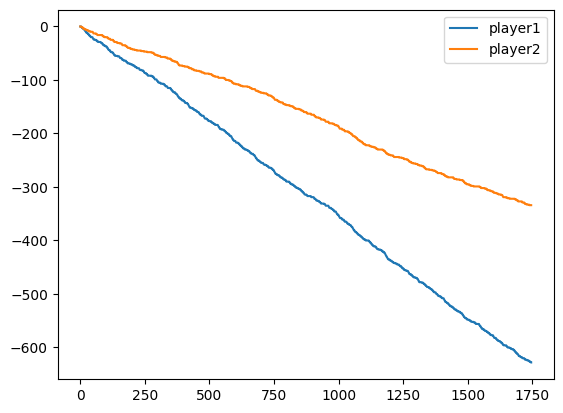


#### Evolution 4


Epoch #1: 1001it [00:01, 682.52it/s, env_step=1000, len=2, n/ep=17, n/st=50, player1/loss=0.414, player2/loss=0.574, rew=-0.12]                          


Epoch #1: test_reward: -0.110000 ± 0.312890, best_reward: -0.110000 ± 0.312890 in #1


Epoch #2: 1001it [00:01, 707.97it/s, env_step=2000, len=2, n/ep=20, n/st=50, player1/loss=0.346, player2/loss=0.586, rew=-0.30]                          


Epoch #2: test_reward: -0.370000 ± 0.482804, best_reward: -0.110000 ± 0.312890 in #1


Epoch #3: 1001it [00:01, 630.34it/s, env_step=3000, len=3, n/ep=16, n/st=50, player1/loss=0.340, player2/loss=0.644, rew=-0.12]                          


Epoch #3: test_reward: -0.100000 ± 0.300000, best_reward: -0.100000 ± 0.300000 in #3
##########

death rate (in %) of player1: 34.1 +- 4.784
death rate (in %) of player2: 19.8 +- 5.617


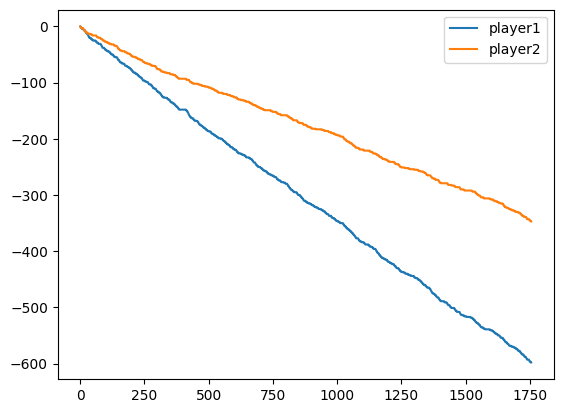


#### Evolution 5


Epoch #1: 1001it [00:01, 687.01it/s, env_step=1000, len=2, n/ep=21, n/st=50, player1/loss=0.427, player2/loss=0.616, rew=-0.33]                          


Epoch #1: test_reward: -0.170000 ± 0.375633, best_reward: -0.140000 ± 0.346987 in #0


Epoch #2: 1001it [00:01, 602.35it/s, env_step=2000, len=2, n/ep=18, n/st=50, player1/loss=0.375, player2/loss=0.655, rew=-0.44]                          


Epoch #2: test_reward: -0.230000 ± 0.420833, best_reward: -0.140000 ± 0.346987 in #0


Epoch #3: 1001it [00:01, 516.42it/s, env_step=3000, len=2, n/ep=20, n/st=50, player1/loss=0.369, player2/loss=0.615, rew=-0.25]                          


Epoch #3: test_reward: -0.200000 ± 0.400000, best_reward: -0.140000 ± 0.346987 in #0


Epoch #4: 1001it [00:01, 667.03it/s, env_step=4000, len=2, n/ep=17, n/st=50, player1/loss=0.344, player2/loss=0.624, rew=-0.41]                          


Epoch #4: test_reward: -0.180000 ± 0.384187, best_reward: -0.140000 ± 0.346987 in #0


Epoch #5: 1001it [00:01, 651.49it/s, env_step=5000, len=3, n/ep=14, n/st=50, player1/loss=0.324, player2/loss=0.677, rew=-0.21]                          


Epoch #5: test_reward: -0.240000 ± 0.427083, best_reward: -0.140000 ± 0.346987 in #0


Epoch #6: 1001it [00:01, 694.55it/s, env_step=6000, len=2, n/ep=18, n/st=50, player1/loss=0.359, player2/loss=0.656, rew=-0.33]                          


Epoch #6: test_reward: -0.190000 ± 0.392301, best_reward: -0.140000 ± 0.346987 in #0


Epoch #7: 1001it [00:01, 682.90it/s, env_step=7000, len=2, n/ep=18, n/st=50, player1/loss=0.355, player2/loss=0.695, rew=-0.28]                          


Epoch #7: test_reward: -0.150000 ± 0.357071, best_reward: -0.140000 ± 0.346987 in #0


Epoch #8: 1001it [00:01, 690.02it/s, env_step=8000, len=3, n/ep=17, n/st=50, player1/loss=0.307, player2/loss=0.675, rew=-0.47]                          


Epoch #8: test_reward: -0.170000 ± 0.375633, best_reward: -0.140000 ± 0.346987 in #0


Epoch #9: 1001it [00:01, 518.12it/s, env_step=9000, len=2, n/ep=19, n/st=50, player1/loss=0.336, player2/loss=0.698, rew=-0.16]                          


Epoch #9: test_reward: -0.220000 ± 0.414246, best_reward: -0.140000 ± 0.346987 in #0


Epoch #10: 1001it [00:01, 692.79it/s, env_step=10000, len=3, n/ep=13, n/st=50, player1/loss=0.351, player2/loss=0.718, rew=-0.31]                          


Epoch #10: test_reward: -0.140000 ± 0.346987, best_reward: -0.140000 ± 0.346987 in #0


Epoch #11: 1001it [00:01, 701.53it/s, env_step=11000, len=3, n/ep=18, n/st=50, player1/loss=0.362, player2/loss=0.738, rew=-0.22]                          


Epoch #11: test_reward: -0.230000 ± 0.420833, best_reward: -0.140000 ± 0.346987 in #0


Epoch #12: 1001it [00:01, 690.36it/s, env_step=12000, len=2, n/ep=19, n/st=50, player1/loss=0.384, player2/loss=0.710, rew=-0.26]                          


Epoch #12: test_reward: -0.240000 ± 0.427083, best_reward: -0.140000 ± 0.346987 in #0


Epoch #13: 1001it [00:01, 712.34it/s, env_step=13000, len=2, n/ep=19, n/st=50, player1/loss=0.382, player2/loss=0.748, rew=-0.32]                          


Epoch #13: test_reward: -0.190000 ± 0.392301, best_reward: -0.140000 ± 0.346987 in #0


Epoch #14: 1001it [00:01, 686.73it/s, env_step=14000, len=3, n/ep=18, n/st=50, player1/loss=0.398, player2/loss=0.762, rew=-0.39]                          


Epoch #14: test_reward: -0.150000 ± 0.357071, best_reward: -0.140000 ± 0.346987 in #0


Epoch #15: 1001it [00:01, 566.72it/s, env_step=15000, len=2, n/ep=19, n/st=50, player1/loss=0.360, player2/loss=0.838, rew=-0.21]                          


Epoch #15: test_reward: -0.150000 ± 0.357071, best_reward: -0.140000 ± 0.346987 in #0


Epoch #16: 1001it [00:01, 548.33it/s, env_step=16000, len=3, n/ep=16, n/st=50, player1/loss=0.397, player2/loss=0.877, rew=-0.19]                          


Epoch #16: test_reward: -0.210000 ± 0.407308, best_reward: -0.140000 ± 0.346987 in #0


Epoch #17: 1001it [00:01, 664.48it/s, env_step=17000, len=2, n/ep=16, n/st=50, player1/loss=0.392, player2/loss=0.816, rew=-0.19]                          


Epoch #17: test_reward: -0.150000 ± 0.357071, best_reward: -0.140000 ± 0.346987 in #0


Epoch #18: 1001it [00:01, 675.26it/s, env_step=18000, len=3, n/ep=16, n/st=50, player1/loss=0.405, player2/loss=0.809, rew=-0.19]                          


Epoch #18: test_reward: -0.210000 ± 0.407308, best_reward: -0.140000 ± 0.346987 in #0


Epoch #19: 1001it [00:01, 683.10it/s, env_step=19000, len=2, n/ep=18, n/st=50, player1/loss=0.376, player2/loss=0.870, rew=-0.11]                          


Epoch #19: test_reward: -0.180000 ± 0.384187, best_reward: -0.140000 ± 0.346987 in #0


Epoch #20: 1001it [00:01, 649.19it/s, env_step=20000, len=2, n/ep=19, n/st=50, player1/loss=0.399, player2/loss=0.882, rew=-0.16]                          


Epoch #20: test_reward: -0.210000 ± 0.407308, best_reward: -0.140000 ± 0.346987 in #0
##########

death rate (in %) of player1: 35.2 +- 7.254
death rate (in %) of player2: 20.0 +- 7.211


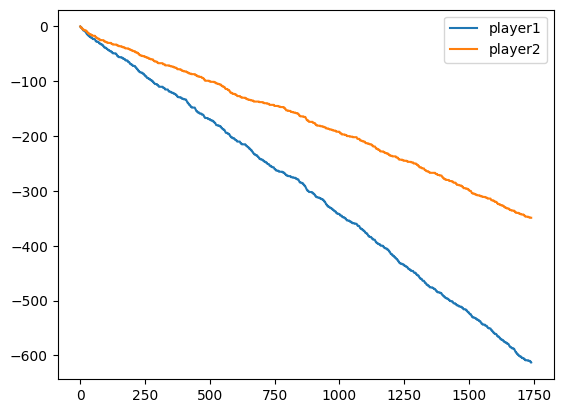


#### Evolution 6


Epoch #1: 1001it [00:01, 664.20it/s, env_step=1000, len=2, n/ep=17, n/st=50, player1/loss=0.493, player2/loss=0.640, rew=-0.24]                          


Epoch #1: test_reward: -0.250000 ± 0.433013, best_reward: -0.250000 ± 0.433013 in #0


Epoch #2: 1001it [00:01, 662.52it/s, env_step=2000, len=3, n/ep=18, n/st=50, player1/loss=0.371, player2/loss=0.678, rew=-0.28]                          


Epoch #2: test_reward: -0.200000 ± 0.400000, best_reward: -0.200000 ± 0.400000 in #2


Epoch #3: 1001it [00:01, 600.24it/s, env_step=3000, len=2, n/ep=18, n/st=50, player1/loss=0.371, player2/loss=0.658, rew=-0.22]                          


Epoch #3: test_reward: -0.160000 ± 0.366606, best_reward: -0.160000 ± 0.366606 in #3


Epoch #4: 1001it [00:01, 508.57it/s, env_step=4000, len=3, n/ep=15, n/st=50, player1/loss=0.340, player2/loss=0.682, rew=-0.13]                          


Epoch #4: test_reward: -0.160000 ± 0.366606, best_reward: -0.160000 ± 0.366606 in #3


Epoch #5: 1001it [00:01, 680.29it/s, env_step=5000, len=2, n/ep=18, n/st=50, player1/loss=0.355, player2/loss=0.676, rew=-0.33]                          


Epoch #5: test_reward: -0.180000 ± 0.384187, best_reward: -0.160000 ± 0.366606 in #3


Epoch #6: 1001it [00:01, 675.56it/s, env_step=6000, len=3, n/ep=15, n/st=50, player1/loss=0.362, player2/loss=0.695, rew=-0.07]                          


Epoch #6: test_reward: -0.250000 ± 0.433013, best_reward: -0.160000 ± 0.366606 in #3


Epoch #7: 1001it [00:01, 691.50it/s, env_step=7000, len=3, n/ep=15, n/st=50, player1/loss=0.329, player2/loss=0.706, rew=-0.33]                          


Epoch #7: test_reward: -0.240000 ± 0.427083, best_reward: -0.160000 ± 0.366606 in #3


Epoch #8: 1001it [00:01, 678.25it/s, env_step=8000, len=2, n/ep=18, n/st=50, player1/loss=0.346, player2/loss=0.728, rew=-0.22]                          


Epoch #8: test_reward: -0.230000 ± 0.420833, best_reward: -0.160000 ± 0.366606 in #3


Epoch #9: 1001it [00:01, 688.10it/s, env_step=9000, len=3, n/ep=17, n/st=50, player1/loss=0.344, player2/loss=0.721, rew=-0.41]                          


Epoch #9: test_reward: -0.210000 ± 0.407308, best_reward: -0.160000 ± 0.366606 in #3


Epoch #10: 1001it [00:02, 484.10it/s, env_step=10000, len=3, n/ep=13, n/st=50, player1/loss=0.330, player2/loss=0.708, rew=-0.15]                          


Epoch #10: test_reward: -0.200000 ± 0.400000, best_reward: -0.160000 ± 0.366606 in #3


Epoch #11: 1001it [00:01, 671.67it/s, env_step=11000, len=3, n/ep=17, n/st=50, player1/loss=0.313, player2/loss=0.775, rew=-0.18]                          


Epoch #11: test_reward: -0.220000 ± 0.414246, best_reward: -0.160000 ± 0.366606 in #3


Epoch #12: 1001it [00:01, 687.15it/s, env_step=12000, len=2, n/ep=20, n/st=50, player1/loss=0.340, player2/loss=0.734, rew=-0.25]                          


Epoch #12: test_reward: -0.150000 ± 0.357071, best_reward: -0.150000 ± 0.357071 in #12


Epoch #13: 1001it [00:01, 685.73it/s, env_step=13000, len=3, n/ep=16, n/st=50, player1/loss=0.350, player2/loss=0.754, rew=-0.44]                          


Epoch #13: test_reward: -0.240000 ± 0.427083, best_reward: -0.150000 ± 0.357071 in #12


Epoch #14: 1001it [00:01, 700.69it/s, env_step=14000, len=2, n/ep=20, n/st=50, player1/loss=0.377, player2/loss=0.755, rew=-0.10]                          


Epoch #14: test_reward: -0.140000 ± 0.346987, best_reward: -0.140000 ± 0.346987 in #14


Epoch #15: 1001it [00:01, 681.83it/s, env_step=15000, len=3, n/ep=17, n/st=50, player1/loss=0.355, player2/loss=0.813, rew=-0.24]                          


Epoch #15: test_reward: -0.280000 ± 0.448999, best_reward: -0.140000 ± 0.346987 in #14


Epoch #16: 1001it [00:01, 550.79it/s, env_step=16000, len=2, n/ep=19, n/st=50, player1/loss=0.358, player2/loss=0.864, rew=-0.16]                          


Epoch #16: test_reward: -0.240000 ± 0.427083, best_reward: -0.140000 ± 0.346987 in #14


Epoch #17: 1001it [00:01, 556.36it/s, env_step=17000, len=3, n/ep=17, n/st=50, player1/loss=0.414, player2/loss=0.803, rew=-0.12]                          


Epoch #17: test_reward: -0.250000 ± 0.433013, best_reward: -0.140000 ± 0.346987 in #14


Epoch #18: 1001it [00:01, 670.35it/s, env_step=18000, len=2, n/ep=18, n/st=50, player1/loss=0.408, player2/loss=0.815, rew=-0.06]                          


Epoch #18: test_reward: -0.210000 ± 0.407308, best_reward: -0.140000 ± 0.346987 in #14


Epoch #19: 1001it [00:01, 691.78it/s, env_step=19000, len=2, n/ep=21, n/st=50, player1/loss=0.394, player2/loss=0.822, rew=-0.14]                          


Epoch #19: test_reward: -0.190000 ± 0.392301, best_reward: -0.140000 ± 0.346987 in #14


Epoch #20: 1001it [00:01, 665.31it/s, env_step=20000, len=2, n/ep=16, n/st=50, player1/loss=0.426, player2/loss=0.835, rew=-0.19]                          


Epoch #20: test_reward: -0.240000 ± 0.427083, best_reward: -0.140000 ± 0.346987 in #14
##########

death rate (in %) of player1: 38.1 +- 3.651
death rate (in %) of player2: 19.8 +- 2.699


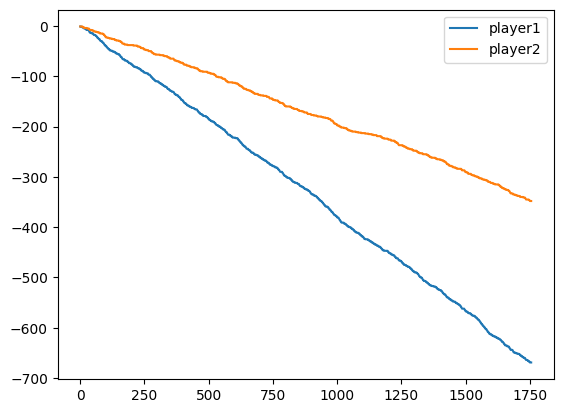


#### Evolution 7


Epoch #1: 1001it [00:01, 673.31it/s, env_step=1000, len=2, n/ep=17, n/st=50, player1/loss=0.595, player2/loss=0.800, rew=-0.29]                          


Epoch #1: test_reward: -0.220000 ± 0.414246, best_reward: -0.220000 ± 0.414246 in #1


Epoch #2: 1001it [00:01, 663.55it/s, env_step=2000, len=3, n/ep=15, n/st=50, player1/loss=0.442, player2/loss=0.797, rew=-0.20]                          


Epoch #2: test_reward: -0.240000 ± 0.427083, best_reward: -0.220000 ± 0.414246 in #1


Epoch #3: 1001it [00:01, 671.34it/s, env_step=3000, len=2, n/ep=18, n/st=50, player1/loss=0.449, player2/loss=0.804, rew=-0.28]                          


Epoch #3: test_reward: -0.230000 ± 0.420833, best_reward: -0.220000 ± 0.414246 in #1


Epoch #4: 1001it [00:01, 589.12it/s, env_step=4000, len=3, n/ep=15, n/st=50, player1/loss=0.390, player2/loss=0.866, rew=-0.27]                          


Epoch #4: test_reward: -0.220000 ± 0.414246, best_reward: -0.220000 ± 0.414246 in #1


Epoch #5: 1001it [00:01, 522.01it/s, env_step=5000, len=3, n/ep=18, n/st=50, player1/loss=0.445, player2/loss=0.889, rew=-0.17]                          


Epoch #5: test_reward: -0.190000 ± 0.392301, best_reward: -0.190000 ± 0.392301 in #5


Epoch #6: 1001it [00:01, 690.15it/s, env_step=6000, len=2, n/ep=19, n/st=50, player1/loss=0.447, player2/loss=0.827, rew=-0.16]                          


Epoch #6: test_reward: -0.230000 ± 0.420833, best_reward: -0.190000 ± 0.392301 in #5


Epoch #7: 1001it [00:01, 672.22it/s, env_step=7000, len=2, n/ep=18, n/st=50, player1/loss=0.412, player2/loss=0.882, rew=-0.17]                          


Epoch #7: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #7


Epoch #8: 1001it [00:01, 678.12it/s, env_step=8000, len=2, n/ep=20, n/st=50, player1/loss=0.444, player2/loss=0.870, rew=-0.25]                          


Epoch #8: test_reward: -0.210000 ± 0.407308, best_reward: -0.170000 ± 0.375633 in #7


Epoch #9: 1001it [00:01, 673.74it/s, env_step=9000, len=2, n/ep=17, n/st=50, player1/loss=0.471, player2/loss=0.838, rew=-0.35]                          


Epoch #9: test_reward: -0.240000 ± 0.427083, best_reward: -0.170000 ± 0.375633 in #7


Epoch #10: 1001it [00:01, 656.72it/s, env_step=10000, len=2, n/ep=21, n/st=50, player1/loss=0.526, player2/loss=0.888, rew=-0.19]                          


Epoch #10: test_reward: -0.230000 ± 0.420833, best_reward: -0.170000 ± 0.375633 in #7


Epoch #11: 1001it [00:02, 490.24it/s, env_step=11000, len=2, n/ep=18, n/st=50, player1/loss=0.498, player2/loss=0.899, rew=-0.44]                          


Epoch #11: test_reward: -0.210000 ± 0.407308, best_reward: -0.170000 ± 0.375633 in #7


Epoch #12: 1001it [00:01, 669.70it/s, env_step=12000, len=2, n/ep=16, n/st=50, player1/loss=0.459, player2/loss=0.932, rew=-0.19]                          


Epoch #12: test_reward: -0.300000 ± 0.458258, best_reward: -0.170000 ± 0.375633 in #7


Epoch #13: 1001it [00:01, 667.61it/s, env_step=13000, len=2, n/ep=16, n/st=50, player1/loss=0.463, player2/loss=0.914, rew=-0.38]                          


Epoch #13: test_reward: -0.190000 ± 0.392301, best_reward: -0.170000 ± 0.375633 in #7


Epoch #14: 1001it [00:01, 686.84it/s, env_step=14000, len=3, n/ep=16, n/st=50, player1/loss=0.463, player2/loss=0.975, rew=-0.25]                          


Epoch #14: test_reward: -0.180000 ± 0.384187, best_reward: -0.170000 ± 0.375633 in #7


Epoch #15: 1001it [00:01, 650.92it/s, env_step=15000, len=2, n/ep=19, n/st=50, player1/loss=0.462, player2/loss=0.998, rew=-0.42]                          


Epoch #15: test_reward: -0.210000 ± 0.407308, best_reward: -0.170000 ± 0.375633 in #7


Epoch #16: 1001it [00:01, 694.47it/s, env_step=16000, len=2, n/ep=18, n/st=50, player1/loss=0.483, player2/loss=1.043, rew=-0.50]                          


Epoch #16: test_reward: -0.200000 ± 0.400000, best_reward: -0.170000 ± 0.375633 in #7


Epoch #17: 1001it [00:01, 536.75it/s, env_step=17000, len=2, n/ep=17, n/st=50, player1/loss=0.524, player2/loss=1.045, rew=-0.29]                          


Epoch #17: test_reward: -0.230000 ± 0.420833, best_reward: -0.170000 ± 0.375633 in #7


Epoch #18: 1001it [00:01, 577.50it/s, env_step=18000, len=3, n/ep=16, n/st=50, player1/loss=0.571, player2/loss=1.062, rew=-0.31]                          


Epoch #18: test_reward: -0.250000 ± 0.433013, best_reward: -0.170000 ± 0.375633 in #7


Epoch #19: 1001it [00:01, 673.46it/s, env_step=19000, len=3, n/ep=17, n/st=50, player1/loss=0.581, player2/loss=1.123, rew=-0.24]                          


Epoch #19: test_reward: -0.220000 ± 0.414246, best_reward: -0.170000 ± 0.375633 in #7


Epoch #20: 1001it [00:01, 666.51it/s, env_step=20000, len=3, n/ep=17, n/st=50, player1/loss=0.557, player2/loss=1.036, rew=-0.29]                          


Epoch #20: test_reward: -0.180000 ± 0.384187, best_reward: -0.170000 ± 0.375633 in #7
##########

death rate (in %) of player1: 34.7 +- 6.751
death rate (in %) of player2: 20.7 +- 5.228


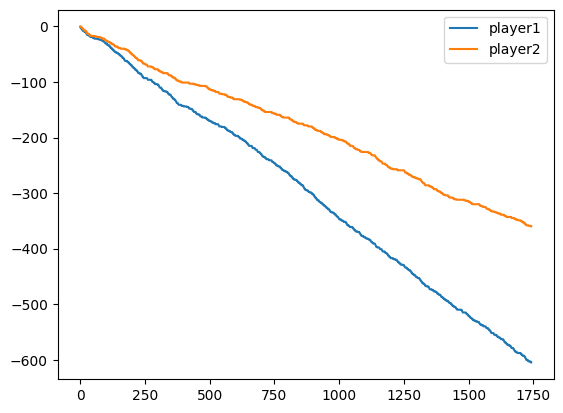


#### Evolution 8


Epoch #1: 1001it [00:01, 668.10it/s, env_step=1000, len=2, n/ep=20, n/st=50, player1/loss=0.629, player2/loss=0.949, rew=-0.15]                          


Epoch #1: test_reward: -0.210000 ± 0.407308, best_reward: -0.110000 ± 0.312890 in #0


Epoch #2: 1001it [00:01, 690.28it/s, env_step=2000, len=3, n/ep=17, n/st=50, player1/loss=0.527, player2/loss=0.868, rew=-0.29]                          


Epoch #2: test_reward: -0.160000 ± 0.366606, best_reward: -0.110000 ± 0.312890 in #0


Epoch #3: 1001it [00:01, 679.87it/s, env_step=3000, len=2, n/ep=21, n/st=50, player1/loss=0.468, player2/loss=0.938, rew=-0.24]                          


Epoch #3: test_reward: -0.170000 ± 0.375633, best_reward: -0.110000 ± 0.312890 in #0


Epoch #4: 1001it [00:01, 672.16it/s, env_step=4000, len=2, n/ep=18, n/st=50, player1/loss=0.481, player2/loss=0.908, rew=-0.17]                          


Epoch #4: test_reward: -0.220000 ± 0.414246, best_reward: -0.110000 ± 0.312890 in #0


Epoch #5: 1001it [00:01, 551.47it/s, env_step=5000, len=2, n/ep=17, n/st=50, player1/loss=0.488, player2/loss=0.936, rew=-0.18]                          


Epoch #5: test_reward: -0.210000 ± 0.407308, best_reward: -0.110000 ± 0.312890 in #0


Epoch #6: 1001it [00:01, 527.42it/s, env_step=6000, len=2, n/ep=18, n/st=50, player1/loss=0.472, player2/loss=0.938, rew=-0.22]                          


Epoch #6: test_reward: -0.270000 ± 0.443959, best_reward: -0.110000 ± 0.312890 in #0


Epoch #7: 1001it [00:01, 672.01it/s, env_step=7000, len=2, n/ep=18, n/st=50, player1/loss=0.477, player2/loss=1.023, rew=-0.28]                          


Epoch #7: test_reward: -0.200000 ± 0.400000, best_reward: -0.110000 ± 0.312890 in #0


Epoch #8: 1001it [00:01, 685.89it/s, env_step=8000, len=3, n/ep=16, n/st=50, player1/loss=0.465, player2/loss=0.923, rew=-0.25]                          


Epoch #8: test_reward: -0.180000 ± 0.384187, best_reward: -0.110000 ± 0.312890 in #0


Epoch #9: 1001it [00:01, 671.28it/s, env_step=9000, len=2, n/ep=17, n/st=50, player1/loss=0.454, player2/loss=0.969, rew=-0.24]                          


Epoch #9: test_reward: -0.170000 ± 0.375633, best_reward: -0.110000 ± 0.312890 in #0


Epoch #10: 1001it [00:01, 678.71it/s, env_step=10000, len=2, n/ep=18, n/st=50, player1/loss=0.505, player2/loss=1.049, rew=-0.11]                          


Epoch #10: test_reward: -0.200000 ± 0.400000, best_reward: -0.110000 ± 0.312890 in #0


Epoch #11: 1001it [00:01, 662.76it/s, env_step=11000, len=3, n/ep=16, n/st=50, player1/loss=0.477, player2/loss=1.067, rew=-0.38]                          


Epoch #11: test_reward: -0.200000 ± 0.400000, best_reward: -0.110000 ± 0.312890 in #0


Epoch #12: 1001it [00:02, 494.47it/s, env_step=12000, len=2, n/ep=19, n/st=50, player1/loss=0.518, player2/loss=1.098, rew=-0.26]                          


Epoch #12: test_reward: -0.160000 ± 0.366606, best_reward: -0.110000 ± 0.312890 in #0


Epoch #13: 1001it [00:01, 680.41it/s, env_step=13000, len=3, n/ep=15, n/st=50, player1/loss=0.541, player2/loss=1.004, rew=0.00]                          


Epoch #13: test_reward: -0.210000 ± 0.407308, best_reward: -0.110000 ± 0.312890 in #0


Epoch #14: 1001it [00:01, 670.27it/s, env_step=14000, len=3, n/ep=16, n/st=50, player1/loss=0.528, player2/loss=1.087, rew=-0.25]                          


Epoch #14: test_reward: -0.320000 ± 0.466476, best_reward: -0.110000 ± 0.312890 in #0


Epoch #15: 1001it [00:01, 665.32it/s, env_step=15000, len=2, n/ep=19, n/st=50, player1/loss=0.535, player2/loss=1.108, rew=-0.21]                          


Epoch #15: test_reward: -0.230000 ± 0.420833, best_reward: -0.110000 ± 0.312890 in #0


Epoch #16: 1001it [00:01, 673.72it/s, env_step=16000, len=3, n/ep=15, n/st=50, player1/loss=0.535, player2/loss=1.147, rew=-0.33]                          


Epoch #16: test_reward: -0.370000 ± 0.482804, best_reward: -0.110000 ± 0.312890 in #0


Epoch #17: 1001it [00:01, 665.44it/s, env_step=17000, len=3, n/ep=16, n/st=50, player1/loss=0.564, player2/loss=1.094, rew=-0.31]                          


Epoch #17: test_reward: -0.240000 ± 0.427083, best_reward: -0.110000 ± 0.312890 in #0


Epoch #18: 1001it [00:01, 525.40it/s, env_step=18000, len=2, n/ep=19, n/st=50, player1/loss=0.582, player2/loss=1.142, rew=-0.16]                          


Epoch #18: test_reward: -0.170000 ± 0.375633, best_reward: -0.110000 ± 0.312890 in #0


Epoch #19: 1001it [00:01, 562.09it/s, env_step=19000, len=3, n/ep=14, n/st=50, player1/loss=0.567, player2/loss=1.214, rew=-0.21]                          


Epoch #19: test_reward: -0.170000 ± 0.375633, best_reward: -0.110000 ± 0.312890 in #0


Epoch #20: 1001it [00:01, 681.75it/s, env_step=20000, len=2, n/ep=18, n/st=50, player1/loss=0.551, player2/loss=1.231, rew=-0.06]                          


Epoch #20: test_reward: -0.240000 ± 0.427083, best_reward: -0.110000 ± 0.312890 in #0
##########

death rate (in %) of player1: 34.5 +- 5.439
death rate (in %) of player2: 20.3 +- 4.738


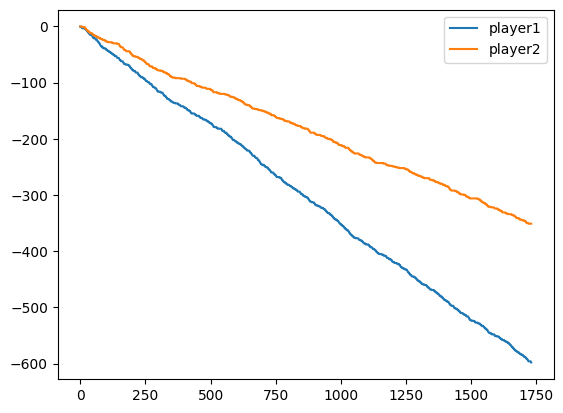


#### Evolution 9


Epoch #1: 1001it [00:01, 553.64it/s, env_step=1000, len=2, n/ep=18, n/st=50, player1/loss=0.674, player2/loss=0.922, rew=-0.17]                          


Epoch #1: test_reward: -0.200000 ± 0.400000, best_reward: -0.200000 ± 0.400000 in #1


Epoch #2: 1001it [00:01, 677.06it/s, env_step=2000, len=3, n/ep=14, n/st=50, player1/loss=0.495, player2/loss=0.965, rew=-0.29]                          


Epoch #2: test_reward: -0.190000 ± 0.392301, best_reward: -0.190000 ± 0.392301 in #2


Epoch #3: 1001it [00:01, 681.31it/s, env_step=3000, len=3, n/ep=18, n/st=50, player1/loss=0.521, player2/loss=0.984, rew=-0.11]                          


Epoch #3: test_reward: -0.160000 ± 0.366606, best_reward: -0.160000 ± 0.366606 in #3


Epoch #4: 1001it [00:01, 691.39it/s, env_step=4000, len=2, n/ep=18, n/st=50, player1/loss=0.499, player2/loss=0.955, rew=-0.28]                          


Epoch #4: test_reward: -0.160000 ± 0.366606, best_reward: -0.160000 ± 0.366606 in #3


Epoch #5: 1001it [00:01, 663.14it/s, env_step=5000, len=3, n/ep=15, n/st=50, player1/loss=0.489, player2/loss=0.990, rew=-0.13]                          


Epoch #5: test_reward: -0.230000 ± 0.420833, best_reward: -0.160000 ± 0.366606 in #3


Epoch #6: 1001it [00:01, 565.12it/s, env_step=6000, len=2, n/ep=18, n/st=50, player1/loss=0.523, player2/loss=1.015, rew=-0.17]                          


Epoch #6: test_reward: -0.320000 ± 0.466476, best_reward: -0.160000 ± 0.366606 in #3


Epoch #7: 1001it [00:01, 542.24it/s, env_step=7000, len=3, n/ep=17, n/st=50, player1/loss=0.540, player2/loss=1.003, rew=-0.47]                          


Epoch #7: test_reward: -0.170000 ± 0.375633, best_reward: -0.160000 ± 0.366606 in #3


Epoch #8: 1001it [00:01, 664.36it/s, env_step=8000, len=3, n/ep=16, n/st=50, player1/loss=0.535, player2/loss=1.044, rew=-0.19]                          


Epoch #8: test_reward: -0.130000 ± 0.336303, best_reward: -0.130000 ± 0.336303 in #8


Epoch #9: 1001it [00:01, 640.49it/s, env_step=9000, len=2, n/ep=17, n/st=50, player1/loss=0.538, player2/loss=1.099, rew=-0.24]                          


Epoch #9: test_reward: -0.240000 ± 0.427083, best_reward: -0.130000 ± 0.336303 in #8


Epoch #10: 1001it [00:01, 676.61it/s, env_step=10000, len=3, n/ep=17, n/st=50, player1/loss=0.544, player2/loss=1.109, rew=-0.24]                          


Epoch #10: test_reward: -0.200000 ± 0.400000, best_reward: -0.130000 ± 0.336303 in #8


Epoch #11: 1001it [00:01, 679.52it/s, env_step=11000, len=2, n/ep=19, n/st=50, player1/loss=0.608, player2/loss=1.203, rew=-0.37]                          


Epoch #11: test_reward: -0.220000 ± 0.414246, best_reward: -0.130000 ± 0.336303 in #8


Epoch #12: 1001it [00:01, 631.76it/s, env_step=12000, len=3, n/ep=16, n/st=50, player1/loss=0.553, player2/loss=1.203, rew=-0.44]                          


Epoch #12: test_reward: -0.270000 ± 0.443959, best_reward: -0.130000 ± 0.336303 in #8


Epoch #13: 1001it [00:01, 504.02it/s, env_step=13000, len=2, n/ep=18, n/st=50, player1/loss=0.581, player2/loss=1.220, rew=-0.17]                          


Epoch #13: test_reward: -0.230000 ± 0.420833, best_reward: -0.130000 ± 0.336303 in #8


Epoch #14: 1001it [00:01, 664.41it/s, env_step=14000, len=3, n/ep=17, n/st=50, player1/loss=0.521, player2/loss=1.229, rew=-0.29]                          


Epoch #14: test_reward: -0.380000 ± 0.485386, best_reward: -0.130000 ± 0.336303 in #8


Epoch #15: 1001it [00:01, 675.16it/s, env_step=15000, len=2, n/ep=20, n/st=50, player1/loss=0.548, player2/loss=1.247, rew=-0.15]                          


Epoch #15: test_reward: -0.210000 ± 0.407308, best_reward: -0.130000 ± 0.336303 in #8


Epoch #16: 1001it [00:01, 682.57it/s, env_step=16000, len=2, n/ep=19, n/st=50, player1/loss=0.543, player2/loss=1.194, rew=-0.42]                          


Epoch #16: test_reward: -0.300000 ± 0.458258, best_reward: -0.130000 ± 0.336303 in #8


Epoch #17: 1001it [00:01, 652.84it/s, env_step=17000, len=3, n/ep=17, n/st=50, player1/loss=0.548, player2/loss=1.197, rew=-0.12]                          


Epoch #17: test_reward: -0.210000 ± 0.407308, best_reward: -0.130000 ± 0.336303 in #8


Epoch #18: 1001it [00:01, 657.95it/s, env_step=18000, len=2, n/ep=19, n/st=50, player1/loss=0.583, player2/loss=1.131, rew=-0.26]                          


Epoch #18: test_reward: -0.290000 ± 0.453762, best_reward: -0.130000 ± 0.336303 in #8


Epoch #19: 1001it [00:02, 492.26it/s, env_step=19000, len=2, n/ep=20, n/st=50, player1/loss=0.582, player2/loss=1.242, rew=-0.25]                          


Epoch #19: test_reward: -0.340000 ± 0.473709, best_reward: -0.130000 ± 0.336303 in #8


Epoch #20: 1001it [00:01, 606.50it/s, env_step=20000, len=2, n/ep=18, n/st=50, player1/loss=0.595, player2/loss=1.250, rew=-0.11]                          


Epoch #20: test_reward: -0.170000 ± 0.375633, best_reward: -0.130000 ± 0.336303 in #8
##########

death rate (in %) of player1: 33.8 +- 5.312
death rate (in %) of player2: 22.0 +- 4.391


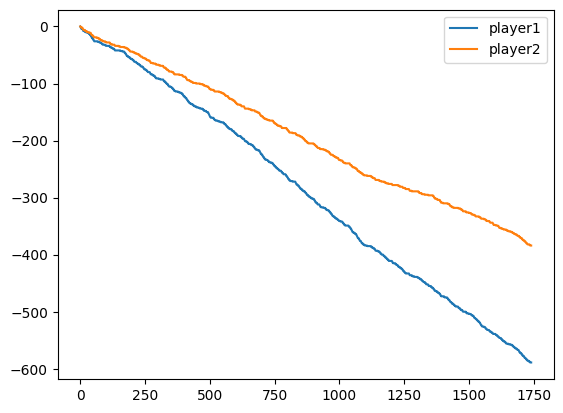


#### Evolution 10


Epoch #1: 1001it [00:01, 519.26it/s, env_step=1000, len=3, n/ep=18, n/st=50, player1/loss=0.809, player2/loss=1.086, rew=-0.28]                          


Epoch #1: test_reward: -0.220000 ± 0.414246, best_reward: -0.170000 ± 0.375633 in #0


Epoch #2: 1001it [00:01, 615.79it/s, env_step=2000, len=2, n/ep=21, n/st=50, player1/loss=0.678, player2/loss=1.193, rew=-0.24]                          


Epoch #2: test_reward: -0.330000 ± 0.470213, best_reward: -0.170000 ± 0.375633 in #0


Epoch #3: 1001it [00:01, 661.58it/s, env_step=3000, len=2, n/ep=17, n/st=50, player1/loss=0.642, player2/loss=1.234, rew=-0.12]                          


Epoch #3: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #0


Epoch #4: 1001it [00:01, 663.40it/s, env_step=4000, len=2, n/ep=17, n/st=50, player1/loss=0.657, player2/loss=1.202, rew=-0.24]                          


Epoch #4: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #0


Epoch #5: 1001it [00:01, 675.48it/s, env_step=5000, len=2, n/ep=16, n/st=50, player1/loss=0.641, player2/loss=1.198, rew=-0.25]                          


Epoch #5: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #0


Epoch #6: 1001it [00:01, 679.55it/s, env_step=6000, len=2, n/ep=17, n/st=50, player1/loss=0.603, player2/loss=1.143, rew=-0.29]                          


Epoch #6: test_reward: -0.200000 ± 0.400000, best_reward: -0.170000 ± 0.375633 in #0


Epoch #7: 1001it [00:01, 539.79it/s, env_step=7000, len=2, n/ep=17, n/st=50, player1/loss=0.570, player2/loss=1.139, rew=-0.24]                          


Epoch #7: test_reward: -0.210000 ± 0.407308, best_reward: -0.170000 ± 0.375633 in #0


Epoch #8: 1001it [00:01, 551.28it/s, env_step=8000, len=2, n/ep=17, n/st=50, player1/loss=0.593, player2/loss=1.299, rew=-0.18]                          


Epoch #8: test_reward: -0.210000 ± 0.407308, best_reward: -0.170000 ± 0.375633 in #0


Epoch #9: 1001it [00:01, 648.16it/s, env_step=9000, len=3, n/ep=18, n/st=50, player1/loss=0.587, player2/loss=1.201, rew=-0.33]                          


Epoch #9: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #0


Epoch #10: 1001it [00:01, 667.48it/s, env_step=10000, len=2, n/ep=19, n/st=50, player1/loss=0.638, player2/loss=1.150, rew=-0.26]                          


Epoch #10: test_reward: -0.180000 ± 0.384187, best_reward: -0.170000 ± 0.375633 in #0


Epoch #11: 1001it [00:01, 651.82it/s, env_step=11000, len=2, n/ep=17, n/st=50, player1/loss=0.560, player2/loss=1.209, rew=-0.18]                          


Epoch #11: test_reward: -0.250000 ± 0.433013, best_reward: -0.170000 ± 0.375633 in #0


Epoch #12: 1001it [00:01, 645.57it/s, env_step=12000, len=3, n/ep=15, n/st=50, player1/loss=0.568, player2/loss=1.151, rew=-0.47]                          


Epoch #12: test_reward: -0.210000 ± 0.407308, best_reward: -0.170000 ± 0.375633 in #0


Epoch #13: 1001it [00:01, 573.49it/s, env_step=13000, len=2, n/ep=17, n/st=50, player1/loss=0.599, player2/loss=1.180, rew=-0.35]                          


Epoch #13: test_reward: -0.260000 ± 0.438634, best_reward: -0.170000 ± 0.375633 in #0


Epoch #14: 1001it [00:02, 497.26it/s, env_step=14000, len=2, n/ep=16, n/st=50, player1/loss=0.569, player2/loss=1.123, rew=-0.50]                          


Epoch #14: test_reward: -0.190000 ± 0.392301, best_reward: -0.170000 ± 0.375633 in #0


Epoch #15: 1001it [00:01, 666.32it/s, env_step=15000, len=2, n/ep=17, n/st=50, player1/loss=0.582, player2/loss=1.187, rew=-0.29]                          


Epoch #15: test_reward: -0.220000 ± 0.414246, best_reward: -0.170000 ± 0.375633 in #0


Epoch #16: 1001it [00:01, 678.63it/s, env_step=16000, len=2, n/ep=21, n/st=50, player1/loss=0.532, player2/loss=1.285, rew=-0.14]                          


Epoch #16: test_reward: -0.220000 ± 0.414246, best_reward: -0.170000 ± 0.375633 in #0


Epoch #17: 1001it [00:01, 679.05it/s, env_step=17000, len=2, n/ep=17, n/st=50, player1/loss=0.626, player2/loss=1.262, rew=-0.41]                          


Epoch #17: test_reward: -0.260000 ± 0.438634, best_reward: -0.170000 ± 0.375633 in #0


Epoch #18: 1001it [00:01, 685.91it/s, env_step=18000, len=3, n/ep=17, n/st=50, player1/loss=0.587, player2/loss=1.233, rew=0.00]                          


Epoch #18: test_reward: -0.210000 ± 0.407308, best_reward: -0.170000 ± 0.375633 in #0


Epoch #19: 1001it [00:01, 673.29it/s, env_step=19000, len=2, n/ep=21, n/st=50, player1/loss=0.605, player2/loss=1.335, rew=-0.24]                          


Epoch #19: test_reward: -0.180000 ± 0.384187, best_reward: -0.170000 ± 0.375633 in #0


Epoch #20: 1001it [00:01, 504.26it/s, env_step=20000, len=3, n/ep=16, n/st=50, player1/loss=0.517, player2/loss=1.308, rew=-0.19]                          


Epoch #20: test_reward: -0.130000 ± 0.336303, best_reward: -0.130000 ± 0.336303 in #20
##########

death rate (in %) of player1: 33.8 +- 5.626
death rate (in %) of player2: 20.3 +- 5.050


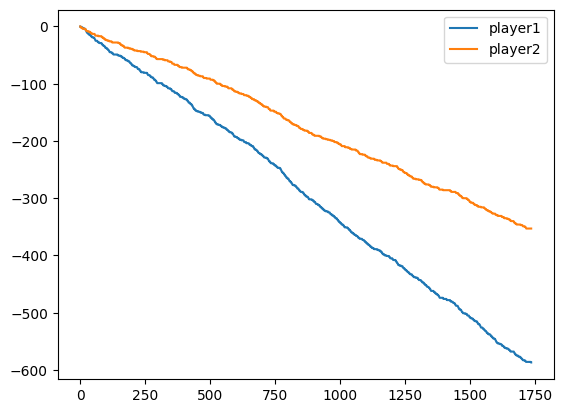

In [26]:
#@title Training
for evolution in range(10):
    print(f"#### Evolution {evolution+1}")
    result = offpolicy_trainer(
        policy=train_policies,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=20,
        step_per_epoch=1000,
        step_per_collect=50,
        episode_per_test=100,
        batch_size=64,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        logger=logger
    )

    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].load_state_dict(torch.load(model_save_path2))
        train_policies.policies[agents[1]].load_state_dict(torch.load(model_save_path2))

    result = test_collector.collect(n_step=5000)
    arr = result["rews"]
    interval_size = 100
    num_intervals = episodes // interval_size

    means = []
    std_devs = []

    for i in range(0, episodes, interval_size):
        interval_data = arr[i:i+interval_size]
        mean = np.mean(interval_data, axis=0)
        means.append(mean)

    for i in range(num_intervals - 1):
        mean_diff = means[i+1] - means[i]
        std_devs.append(mean_diff)

    avg = (np.mean(arr, axis=0)) * -100
    std_dev = np.std(std_devs, axis=0) * 100

    print("#"*10)
    print()
    print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
    print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
    plt.plot(arr.cumsum(axis=0))
    plt.legend(("player1", "player2"))
    plt.show()

    print()

In [27]:
#@title Save Policy as CSV

df = []
obs = []

for days_left in range(1, 3):
    for player1_life_points in range(4):
        for player2_life_points in range(4):
            for payoff in [0.2, 0.4]:
                for player1_action in range(0, 3):
                    for player2_action in range(0, 3):
                        curr_obs = [
                            days_left, 
                            player1_life_points, 
                            player2_life_points, 
                            payoff,
                            payoff,
                            player1_action, 
                            player2_action
                        ]
                        obs.append({
                            'agent_id': 'player2',
                            'obs': np.array([curr_obs], dtype='float32'),
                            'mask': [True, True, False]
                        })
                        df.append(curr_obs)

cols = [
    "days_left", 
    "player1_life_points", 
    "player2_life_points", 
    "player1_prob_payoff",
    "player2_prob_payoff",
    "player1_previous_action", 
    "player2_previous_action"
]
df = pd.DataFrame(df, columns=cols)

scaler = MinMaxScaler(feature_range=(0, 1))

df["player2_predicted_action"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).act
df["player2_logit_wait"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 0]
df["player2_logit_play"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 1]
df["player2_logit_diff"] = scaler.fit_transform((df["player2_logit_play"] - df["player2_logit_wait"]).values[:, None])

df["player1_previous_action"] = df["player1_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_previous_action"] = df["player2_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_predicted_action"] = df["player2_predicted_action"].map({0: "wait", 1: "play"})

df.to_csv("outcome_table.csv", index=False)

df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play,player2_logit_diff
0,1,0,0,0.2,0.2,wait,wait,play,-4.554651,-4.114267,0.663413
1,1,0,0,0.2,0.2,wait,play,wait,-4.488482,-4.932368,0.530981
2,1,0,0,0.2,0.2,wait,none,wait,-4.583046,-5.817541,0.412576
3,1,0,0,0.2,0.2,play,wait,play,-4.693981,-4.341769,0.650208
4,1,0,0,0.2,0.2,play,play,play,-4.700997,-4.369873,0.647050


In [28]:
#@title Visualize policy (mean gameplay)
(df["player2_predicted_action"] == "play").mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5243055555555556

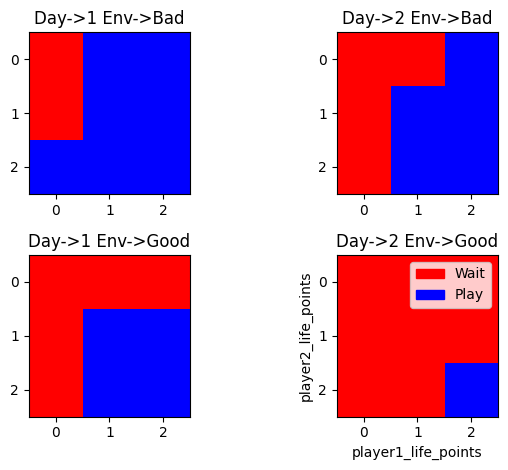

In [29]:
#@title Visualize policy
##TODO display logits instead
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

arr = df.loc[
    (df["days_left"] == 1) & 
    (df["player1_prob_payoff"] < 0.3) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & 
    (df["player1_previous_action"] == "none") & 
    (df["player2_previous_action"] == "none"), "player2_predicted_action"
].map({"wait": 0, "play": 1}).values

ax1.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax1.set_title("Day->1 Env->Bad")

arr = df.loc[
    (df["days_left"] == 2) & 
    (df["player1_prob_payoff"] < 0.3) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & 
    (df["player1_previous_action"] == "none") & 
    (df["player2_previous_action"] == "none"), "player2_predicted_action"
].map({"wait": 0, "play": 1}).values

ax2.imshow(np.reshape(arr, (3, 3)), cmap='bwr', vmin=0, vmax=1)
ax2.set_title("Day->2 Env->Bad")

arr = df.loc[
    (df["days_left"] == 1) & 
    (df["player1_prob_payoff"] > 0.3) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & 
    (df["player1_previous_action"] == "none") & 
    (df["player2_previous_action"] == "none"), "player2_predicted_action"
].map({"wait": 0, "play": 1}).values

ax3.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax3.set_title("Day->1 Env->Good")

arr = df.loc[
    (df["days_left"] == 2) & 
    (df["player1_prob_payoff"] > 0.3) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & 
    (df["player1_previous_action"] == "none") & 
    (df["player2_previous_action"] == "none"), "player2_predicted_action"
].map({"wait": 0, "play": 1}).values

ax = ax4.imshow(np.reshape(arr, (3, 3)), cmap='bwr', vmin=0, vmax=1)
ax4.set_title("Day->2 Env->Good")
ax4.set_xlabel("player1_life_points")
ax4.set_ylabel("player2_life_points")

red_patch = mpatches.Patch(color='red', label='Wait')
blue_patch = mpatches.Patch(color='blue', label='Play')

plt.legend(handles=[red_patch, blue_patch])

fig.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate (in %) of player1: 31.5 +- 7.249
death rate (in %) of player2: 18.2 +- 5.418


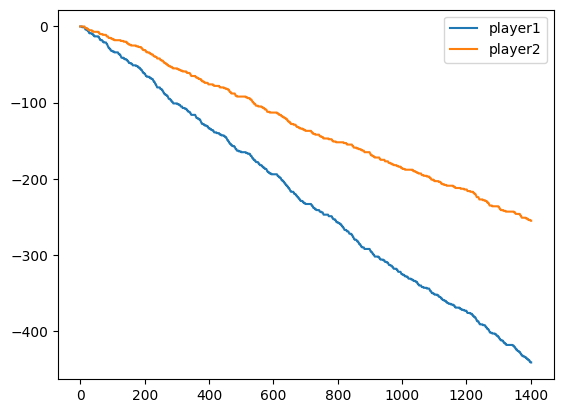

In [30]:
#@title Case - optimal vs optimal
policy = MultiAgentPolicyManager([OptimalPolicy(), OptimalPolicy()],  _get_env())
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()